### 1. IMPORTS ET VISUALISATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('healthcare_dataset.csv')

print(f"Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes.")
df.head()

Le dataset contient 55500 lignes et 15 colonnes.


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


### 2. NETTOYAGE DES DONNEES

In [3]:
# Suppression des colonnes qui n'aident pas à prédire le coût (noms, hôpitaux, etc.)
cols_to_drop = ['Name', 'Hospital', 'Doctor', 'Room Number']
df = df.drop(columns=cols_to_drop)

In [4]:
# Transformation des dates car une date brute ne sert à rien en ici,
# c'est la durée du séjour qui compte pour la facturation.
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# Calcul du nombre de jours passés à l'hôpital
df['Duration_Days'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# On vérifie s'il y a des durées aberrantes (négatives)
print("Nombre de séjours avec durée incohérente :", df[df['Duration_Days'] < 0].shape[0])

# Enfin on peut supprimer les colonnes de dates originales
df = df.drop(columns=['Date of Admission', 'Discharge Date'])

Nombre de séjours avec durée incohérente : 0


In [7]:
#vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


Valeurs manquantes par colonne :
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Insurance Provider    0
Billing Amount        0
Admission Type        0
Medication            0
Test Results          0
Duration_Days         0
dtype: int64


 ### 3. ANALYSE EXPLORATRICE CIBLEE (EDA)

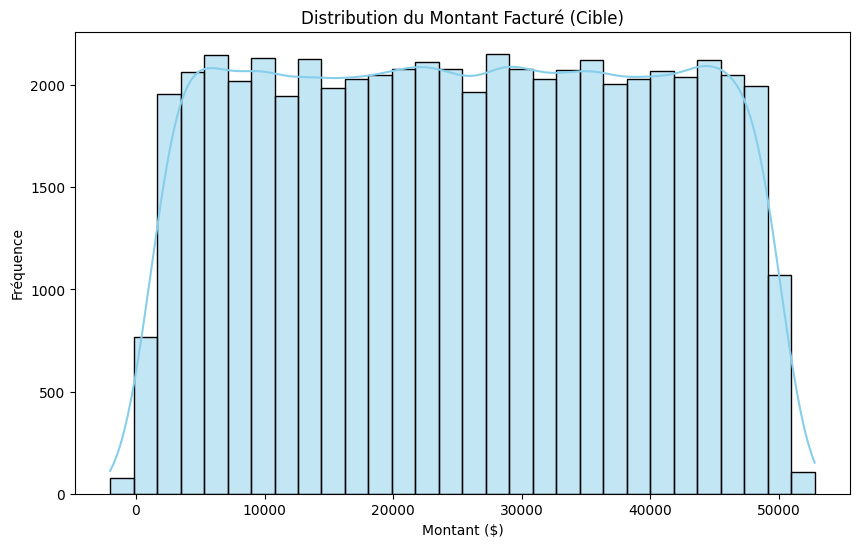

In [10]:
# On Regarder d'abord la distribution de ce qu'on veut prédire
plt.figure(figsize=(10, 6))
sns.histplot(df['Billing Amount'], bins=30, kde=True, color='skyblue')
plt.title('Distribution du Montant Facturé (Cible)')
plt.xlabel('Montant ($)')
plt.ylabel('Fréquence')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\1956190454.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Medical Condition', y='Billing Amount', data=df, palette='Set2')


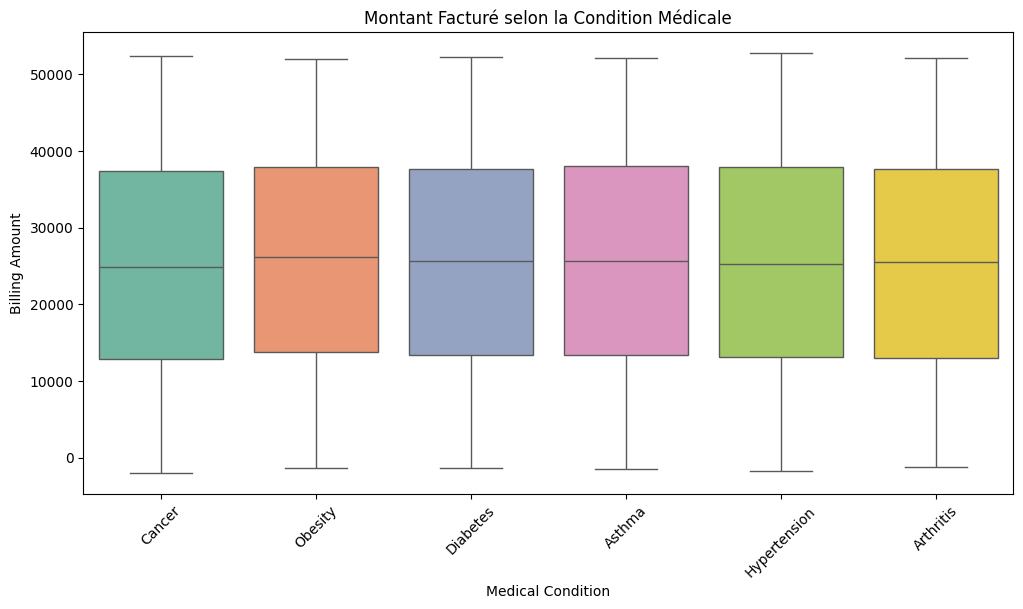

In [11]:
# On utilise un boxplot pour voir la répartition par condition médicale
plt.figure(figsize=(12, 6))
sns.boxplot(x='Medical Condition', y='Billing Amount', data=df, palette='Set2')
plt.title('Montant Facturé selon la Condition Médicale')
plt.xticks(rotation=45)
plt.show()

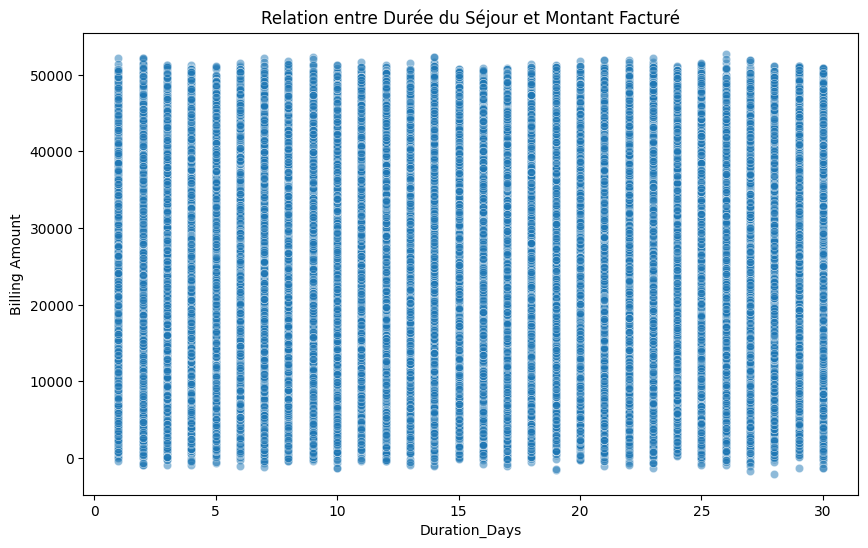

In [12]:
# On regarde si la durée du séjour impacte le prix (ce qui serait logique)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration_Days', y='Billing Amount', data=df, alpha=0.5)
plt.title('Relation entre Durée du Séjour et Montant Facturé')
plt.show()

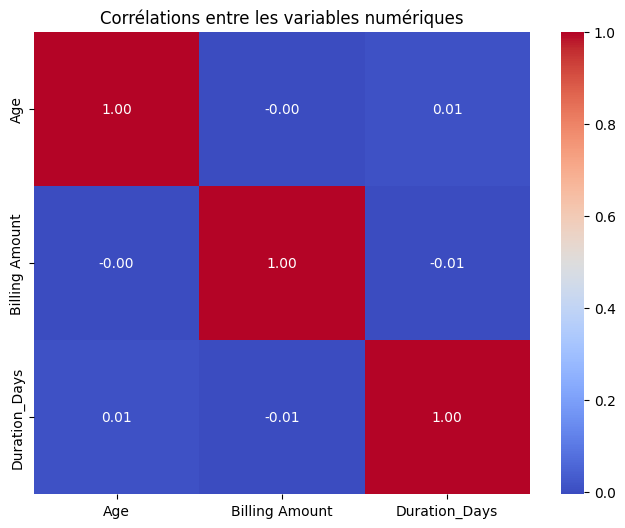

In [13]:
# Enfin, une petite heatmap pour voir les corrélations numériques
plt.figure(figsize=(8, 6))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Corrélations entre les variables numériques')
plt.show()

### 4.PREPROCESSING

In [22]:
# Encodage des variables catégorielles
# On transforme les colonnes comme 'Gender', 'Blood Type', etc., en colonnes numériques.

cols_to_encode = ['Gender', 'Blood Type', 'Medical Condition',
                  'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']

df_encoded = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

In [24]:
# Séparation des caractéristiques (X) et de la cible (y)
X = df_encoded.drop('Billing Amount', axis=1)
y = df_encoded['Billing Amount']

# Découpage en set d'entraînement (80%) et de test (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille du train set : {X_train.shape}")
print(f"Taille du test set : {X_test.shape}")

Taille du train set : (44400, 27)
Taille du test set : (11100, 27)


#### SCALING

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# On initialise le scaler
scaler = StandardScaler()

# On ajuste sur le train set ET on transforme
X_train_scaled = scaler.fit_transform(X_train)

# On transforme le test set
X_test_scaled = scaler.transform(X_test)

print("Mise à l'échelle terminée avec succès.")

Mise à l'échelle terminée avec succès.


### 5. OPTIMISATION DU MODÈLE

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [40]:
# On réduit la complexité pour avoir un fichier .pkl léger
# POUR REPONDRE AUX BESOINS DU CLOUD

# n_estimators=50 au lieu de 100 ou 200
# max_depth=10 pour éviter que l'arbre ne devienne gigantesque
optimized_rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Entraînement du modèle allégé...")
optimized_rf.fit(X_train_scaled, y_train)

# Évaluation
y_pred_rf = optimized_rf.predict(X_test_scaled)
print(f"MAE : {mean_absolute_error(y_test, y_pred_rf):.2f} $")
print(f"R2 : {r2_score(y_test, y_pred_rf):.4f}")

best_rf = optimized_rf

Entraînement du modèle allégé...
MAE : 12163.72 $
R2 : 0.0028


### 6. SAUVEGARDE DU MODELE ET DU SCALER

In [41]:
import pickle

In [44]:
# Sauvegarde du modèle optimisé
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf, model_file)

# Sauvegarde du scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [45]:
# Sauvegarde de la liste des colonnes
model_columns = list(X.columns)
with open('model_columns.pkl', 'wb') as cols_file:
    pickle.dump(model_columns, cols_file)

print("Fichiers sauvegardés : best_model.pkl, scaler.pkl, model_columns.pkl")

Fichiers sauvegardés : best_model.pkl, scaler.pkl, model_columns.pkl
